In [1]:
%matplotlib inline  

In [2]:
import os
import sys
import math
import numpy as np
import math
import torch
import pickle
import matplotlib.pyplot as plt
import torch.utils.data as data_utils

from pathlib import Path

In [3]:
os.chdir("..")

In [4]:
from optbnn.gp.models.gpr import GPR
from optbnn.gp import kernels, mean_functions
from optbnn.bnn.reparam_nets import GaussianMLPReparameterization
from optbnn.bnn.nets.mlp import MLP
from optbnn.bnn.likelihoods import LikCategorical
from optbnn.bnn.priors import OptimGaussianPrior
from optbnn.prior_mappers.wasserstein_mapper import MapperWasserstein, WassersteinDistance
from optbnn.utils.rand_generators import ClassificationGenerator
from optbnn.utils.normalization import normalize_data
from optbnn.utils import util
from optbnn.sgmcmc_bayes_net.classification_net import ClassificationNet

PrettyTable not installed. Running without it


In [5]:
util.set_seed(123)

# 1. Load `Banana` dataset

In [6]:
DATA_DIR = "./data/banana"
OUT_DIR = "./exp/banana"

In [7]:
# Load banana dataset
X = np.loadtxt(os.path.join(
    DATA_DIR, "banana_X_train"), delimiter=",").astype(np.float32)
y = np.loadtxt(os.path.join(
    DATA_DIR, "banana_Y_train"), delimiter=",").reshape([-1]).astype(np.int64)

In [8]:
# Setup directories
ckpt_dir = os.path.join(OUT_DIR, "ckpts")
figs_dir = os.path.join(OUT_DIR, "figs")
util.ensure_dir(ckpt_dir)
util.ensure_dir(figs_dir)

# 2. Configure hyper-parameters

Configure the neural network architecture. In this experiment, we use a 2-hidden layer MLP with tanh activation function. The number of hidden units at each layer is 100.

In [9]:
input_dim = 2
output_dim = 2
hidden_dims = [100] * 2
activation_fn = "tanh"

Configure the hyper-parameters ofWasserstein optimization.  

In [10]:
mapper_batch_size = 256        # The size of the measurement set. The measurement points are sampled from the training data.
mapper_n_samples = 128         # The size of mini batch used in Wasserstein optimization
mapper_n_lipschitz_iters = 200 # The number of Lipschitz function iterations per prior iteration
mapper_n_prior_iters = 200     # The number of prior iterations
mapper_lipschitz_lr = 0.02     # The learning rate for the opimization of the Lipschitz function (inner loop)
mapper_prior_lr = 0.05         # The learning rate for the optimization of the prior (outer loop)

To reduce the running time of this demonstration, we use 100 iterations of Wasserstein optimization instead of 200 as used in the paper. However, the results are mostly similar. In order to reproduce exactly the results in the paper, please change `mapper_n_prior_iters = 100` to `mapper_n_prior_iters = 200`.

Configure the hyper-parameters for the SGHMC sampler.  

In [11]:
sampler_batch_size = 32
sampling_configs = {
    "batch_size": sampler_batch_size, # Mini-batch size
    "num_samples": 60,                # Total number of samples for each chain 
    "n_discarded": 10,                # Number of the first samples to be discared for each chain
    "num_burn_in_steps": 200,         # Number of burn-in steps
    "keep_every": 200,                # Thinning interval
    "lr": 1e-2,                       # Step size
    "num_chains": 1,                  # Number of chains
    "mdecay": 1e-2,                   # Momentum coefficient
    "print_every_n_samples": 5
}

Attention, to reduce the running time of this demonstration, we use just 1 chain of sampling instead of 4 chains as used in the paper. To reproduce exactly the results in the paper, please change `"num_chains": 1` to `"num_chains": 4`, and `"num_samples": 60` to `"num_samples": 40`.

Setup the values of lengthscales and variances of the taret GP prior.

In [12]:
variances = [1, 32]
lengthscales = [1, 4, 16]

# 3. Optimize priors

In [13]:
for variance in variances:
    for lengthscale in lengthscales:
        print("----" * 20)
        print("Lengthscale: {}; Variance: {}".format(lengthscale, variance))

        # Initialize data loader for the mapper
        data_loader = data_utils.DataLoader(
                            data_utils.TensorDataset(torch.from_numpy(X),
                                                     torch.from_numpy(y)),
                            batch_size=mapper_batch_size, shuffle=True)
        
        # Setup the measurement set generator
        # We draw measurement points from the training data
        rand_generator = ClassificationGenerator(data_loader)

        # Specify the target GP prior
        X_, y_ = rand_generator.get(return_label=True)
        kernel = kernels.RBF(
            input_dim,
            lengthscales=torch.tensor([lengthscale], dtype=torch.double),
            variance=torch.tensor([variance], dtype=torch.double))
        gp = GPR(X_.reshape([mapper_batch_size, -1]).double(),
                            util.to_one_hot(y_).double(),
                            kern=kernel, mean_function=mean_functions.Zero())

        # Initialize tunable MLP prior
        mlp_reparam = GaussianMLPReparameterization(input_dim, output_dim,
            hidden_dims, activation_fn, scaled_variance=True)
        
        # Initialize the mapper
        saved_dir = os.path.join(OUT_DIR, "len_{}_var_{}".format(
            lengthscale, variance))
        mapper = MapperWasserstein(gp, mlp_reparam, rand_generator, out_dir=saved_dir,
                                   output_dim=output_dim,
                                   n_data=mapper_batch_size,
                                   wasserstein_steps=(0, mapper_n_lipschitz_iters),
                                   wasserstein_lr=mapper_lipschitz_lr,
                                   wasserstein_thres=0.1,
                                   n_gpu=1)
        
        # Start optimization
        print("Start optimizing prior")
        w_hist = mapper.optimize(num_iters=mapper_n_prior_iters, n_samples=mapper_n_samples,
                        lr=mapper_prior_lr, print_every=5,
                        save_ckpt_every=20, debug=True)
        path = os.path.join(saved_dir, "wsr_values.log")
        np.savetxt(path, w_hist, fmt='%.6e')
        print("----" * 20)

--------------------------------------------------------------------------------
Lengthscale: 1; Variance: 1
Start optimizing prior
>>> Iteration #   1: Wasserstein Dist 54.5873
>>> Iteration #   5: Wasserstein Dist 17.4023
>>> Iteration #  10: Wasserstein Dist 12.8748
>>> Iteration #  15: Wasserstein Dist 9.0932
>>> Iteration #  20: Wasserstein Dist 7.8626
>>> Iteration #  25: Wasserstein Dist 5.7614
>>> Iteration #  30: Wasserstein Dist 8.9110
>>> Iteration #  35: Wasserstein Dist 7.9453
>>> Iteration #  40: Wasserstein Dist 5.9577
>>> Iteration #  45: Wasserstein Dist 5.0367
>>> Iteration #  50: Wasserstein Dist 5.4131
>>> Iteration #  55: Wasserstein Dist 6.4526
>>> Iteration #  60: Wasserstein Dist 5.9473
>>> Iteration #  65: Wasserstein Dist 3.3516
>>> Iteration #  70: Wasserstein Dist 5.9895
>>> Iteration #  75: Wasserstein Dist 4.4628
>>> Iteration #  80: Wasserstein Dist 3.5955
>>> Iteration #  85: Wasserstein Dist 4.3478
>>> Iteration #  90: Wasserstein Dist 7.4153
>>> Iterat

## 3.1 Visualize progressions of the priors optimization

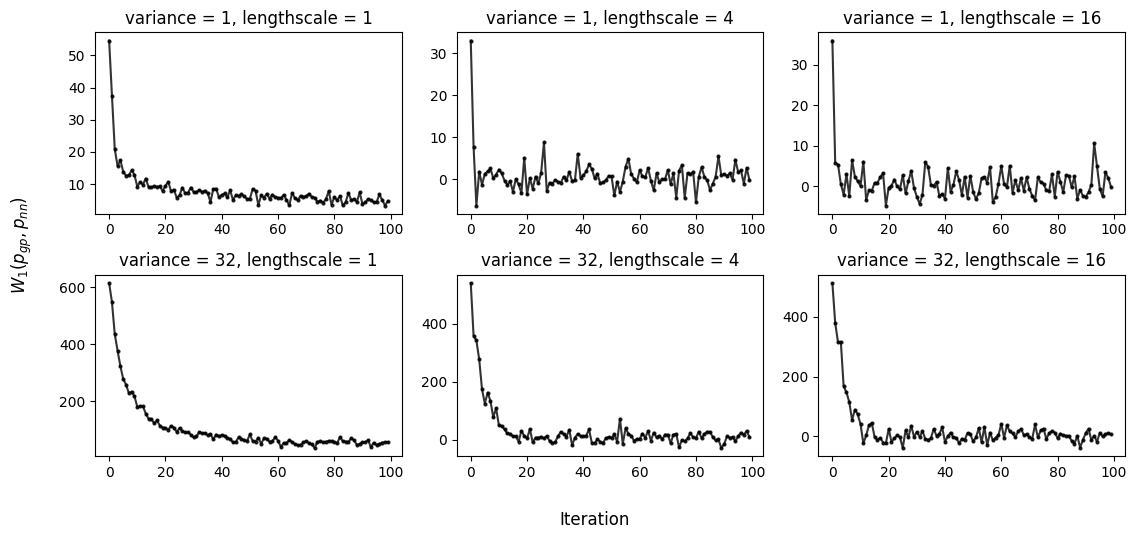

In [14]:
fig, axs = plt.subplots(2, 3, figsize=(11, 5), sharex=False, dpi=100)

for i, variance in enumerate(variances):
    for j, lengthscale in enumerate(lengthscales):
        wdist_file = os.path.join(OUT_DIR, "len_{}_var_{}".format(lengthscale, variance),
                                  "wsr_values.log")
        wdist_vals = np.loadtxt(wdist_file)
        
        axs[i, j].plot(wdist_vals, "-ok", ms=2, alpha=0.8)
        axs[i, j].set_title(r"variance = {}, lengthscale = {}".format(variance, lengthscale))


fig.text(0.5, -0.05, "Iteration", ha="center", va="center", fontsize=12)
fig.text(-0.02, 0.5, r"$W_1(p_{gp}, p_{nn})$", ha="center", va="center", rotation=90, fontsize=12)
        
plt.tight_layout()
plt.show()

# 4. Sample from posterior using SGHMC sampler

In [15]:
for variance in variances:
    for lengthscale in lengthscales:
        print("----" * 20)
        print("Lengthscale: {}; Variance: {}".format(lengthscale, variance))
        
        data_loader = data_utils.DataLoader(
                    data_utils.TensorDataset(torch.from_numpy(X), torch.from_numpy(y)),
                    batch_size=sampler_batch_size, shuffle=True)
        
        # Setup the likelihood
        net = MLP(input_dim, output_dim, hidden_dims, activation_fn,
                task="classification")
        likelihood = LikCategorical()
        
        # Load the optimized prior
        saved_dir = os.path.join(OUT_DIR, "len_{}_var_{}".format(
            lengthscale, variance))
        ckpt_path = os.path.join(saved_dir, "ckpts", "it-{}.ckpt".format(mapper_n_prior_iters))
        print("Loading prior: {}".format(ckpt_path))
        prior = OptimGaussianPrior(ckpt_path)
        
        # Initialize the Bayesian net
        samples_dir = os.path.join(saved_dir, "samples")
        util.ensure_dir(samples_dir)
        bayes_net = ClassificationNet(net, likelihood, prior, saved_dir, n_gpu=0)
        
        # Start sampling using SGHMC sampler
        bayes_net.sample_multi_chains(data_loader=data_loader, **sampling_configs)
        mean_preds, preds = bayes_net.evaluate(data_loader, True, True)

        # Make predictions using the posterior
        preds = []
        pred_means = []
        targets = []
        with torch.no_grad():
            for i, (data, target) in enumerate(data_loader):
                pred_mean, pred = bayes_net.predict(
                    data, return_individual_predictions=True,
                    num_samples=40)

                pred_means.append(pred_mean)
                preds.append(pred)
                targets.append(target)

        pred_means = torch.cat(pred_means, dim=0).cpu().numpy()
        preds = torch.cat(preds, dim=1).cpu().numpy()
        targets = torch.cat(targets, dim=0).cpu().numpy()
        x_grid = np.linspace(-3, 3, 40)
        xx, yy = np.meshgrid(x_grid, x_grid)
        Xplot = np.vstack((xx.flatten(), yy.flatten())).T

        p, _ = bayes_net.predict(torch.from_numpy(Xplot).float(), True, True)
        p = p.cpu().numpy()
        
        # Save the predictions to file
        data = { "xx": xx, "yy": yy, "X": X, "y": y, "p": p}
        with open(os.path.join(saved_dir, "preds.pickle"), 'wb') as f:
            pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)
        
        print("----" * 20)

--------------------------------------------------------------------------------
Lengthscale: 1; Variance: 1
Loading prior: ./exp/banana/len_1_var_1/ckpts/it-100.ckpt
Chain: 0
Samples #     5 : NLL = 0.27772 Acc = 0.8750 
Samples #    10 : NLL = 0.29513 Acc = 0.9375 
Samples #    15 : NLL = 0.22266 Acc = 1.0000 
Samples #    20 : NLL = 0.42091 Acc = 0.7500 
Samples #    25 : NLL = 0.31748 Acc = 0.8750 
Samples #    30 : NLL = 0.34514 Acc = 0.8750 
Samples #    35 : NLL = 0.32597 Acc = 0.9062 
Samples #    40 : NLL = 0.30952 Acc = 0.8438 
Samples #    45 : NLL = 0.30675 Acc = 0.8438 
Samples #    50 : NLL = 0.20913 Acc = 0.9688 


50it [00:00, 131.49it/s]


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Lengthscale: 4; Variance: 1
Loading prior: ./exp/banana/len_4_var_1/ckpts/it-100.ckpt
Chain: 0
Samples #     5 : NLL = 0.48125 Acc = 0.8750 
Samples #    10 : NLL = 0.51313 Acc = 0.7500 
Samples #    15 : NLL = 0.42344 Acc = 0.9375 
Samples #    20 : NLL = 0.41240 Acc = 1.0000 
Samples #    25 : NLL = 0.48556 Acc = 0.8750 
Samples #    30 : NLL = 0.46861 Acc = 0.8125 
Samples #    35 : NLL = 0.48828 Acc = 0.8438 
Samples #    40 : NLL = 0.45770 Acc = 0.8125 
Samples #    45 : NLL = 0.46781 Acc = 0.8438 
Samples #    50 : NLL = 0.49487 Acc = 0.8125 


50it [00:00, 127.13it/s]


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Lengthscale: 16; Variance: 1
Loading prior: ./exp/banana/len_16_var_1/ckpts/it-100.ckpt
Chain: 0
Samples #     5 : NLL = 0.63382 Acc = 0.6875 
Samples #    10 : NLL = 0.67275 Acc = 0.6250 
Samples #    15 : NLL = 0.72635 Acc = 0.4688 
Samples #    20 : NLL = 0.63754 Acc = 0.8125 
Samples #    25 : NLL = 0.63591 Acc = 0.7812 
Samples #    30 : NLL = 0.61912 Acc = 0.8438 
Samples #    35 : NLL = 0.66619 Acc = 0.6562 
Samples #    40 : NLL = 0.70307 Acc = 0.5938 
Samples #    45 : NLL = 0.68975 Acc = 0.6250 
Samples #    50 : NLL = 0.65606 Acc = 0.6250 


50it [00:00, 97.27it/s]


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Lengthscale: 1; Variance: 32
Loading prior: ./exp/banana/len_1_var_32/ckpts/it-100.ckpt
Chain: 0
Samples #     5 : NLL = 0.21616 Acc = 0.9062 
Samples #    10 : NLL = 0.12240 Acc = 0.9688 
Samples #    15 : NLL = 0.10796 Acc = 0.9688 
Samples #    20 : NLL = 0.17585 Acc = 1.0000 
Samples #    25 : NLL = 0.20191 Acc = 0.9688 
Samples #    30 : NLL = 0.17838 Acc = 0.9375 
Samples #    35 : NLL = 0.22052 Acc = 0.9375 
Samples #    40 : NLL = 0.12415 Acc = 0.9688 
Samples #    45 : NLL = 0.07861 Acc = 0.9688 
Samples #    50 : NLL = 0.27677 Acc = 0.9062 


50it [00:00, 91.47it/s] 


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Lengthscale: 4; Variance: 32
Loading prior: ./exp/banana/len_4_var_32/ckpts/it-100.ckpt
Chain: 0
Samples #     5 : NLL = 0.21303 Acc = 0.9375 
Samples #    10 : NLL = 0.33554 Acc = 0.7812 
Samples #    15 : NLL = 0.23112 Acc = 0.9688 
Samples #    20 : NLL = 0.27594 Acc = 0.8750 
Samples #    25 : NLL = 0.20941 Acc = 0.9375 
Samples #    30 : NLL = 0.39391 Acc = 0.8125 
Samples #    35 : NLL = 0.33282 Acc = 0.8438 
Samples #    40 : NLL = 0.27397 Acc = 0.8438 
Samples #    45 : NLL = 0.28782 Acc = 0.8750 
Samples #    50 : NLL = 0.17933 Acc = 0.9375 


50it [00:00, 125.13it/s]


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Lengthscale: 16; Variance: 32
Loading prior: ./exp/banana/len_16_var_32/ckpts/it-100.ckpt
Chain: 0
Samples #     5 : NLL = 0.44351 Acc = 0.8750 
Samples #    10 : NLL = 0.39814 Acc = 0.8438 
Samples #    15 : NLL = 0.38207 Acc = 0.8438 
Samples #    20 : NLL = 0.33051 Acc = 0.9375 
Samples #    25 : NLL = 0.37862 Acc = 0.8750 
Samples #    30 : NLL = 0.31279 Acc = 0.9375 
Samples #    35 : NLL = 0.32941 Acc = 0.9062 
Samples #    40 : NLL = 0.41201 Acc = 0.9062 
Samples #    45 : NLL = 0.45198 Acc = 0.7812 
Samples #    50 : NLL = 0.45122 Acc = 0.8438 


50it [00:00, 130.50it/s]


--------------------------------------------------------------------------------


# 5. Visualize predictive posterior

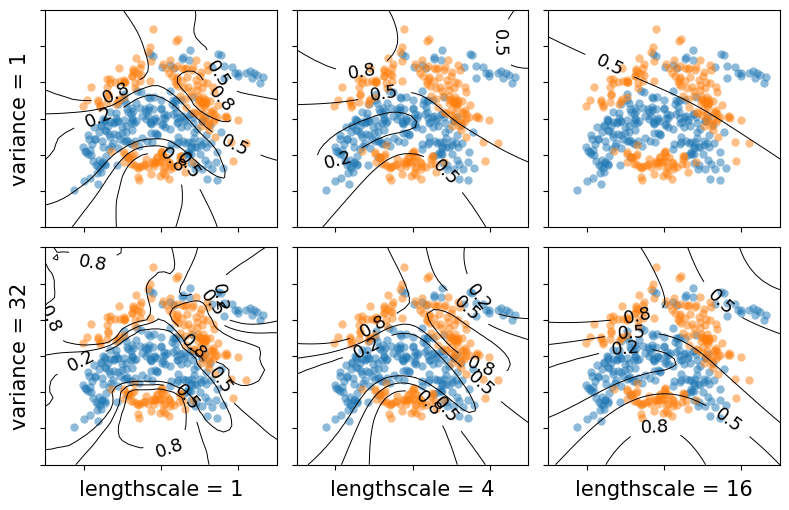

In [92]:
fig, ax = plt.subplots(nrows=2, ncols=3, tight_layout=False,
                        figsize=(8, 5.2), sharex=True, sharey=True, dpi=100)

for i, variance in enumerate(variances):
    for j, lengthscale in enumerate(lengthscales):
        data_file = os.path.join(OUT_DIR, "len_{}_var_{}".format(lengthscale, variance),
                                  "preds.pickle")
        
        with open(data_file, "rb") as f:
            data = pickle.load(f)
        
        X = data['X']
        y = data['y']
        p = data['p']
        xx = data['xx']
        yy = data['yy']

        mask = y.reshape([-1, 1])[:, 0] == 1
        Xplot = np.vstack((xx.flatten(), yy.flatten())).T
        
        ax[i, j].plot(X[mask, 0], X[mask, 1], "oC0", mew=0, alpha=0.5, ms=6)
        ax[i, j].plot(X[np.logical_not(mask), 0], X[np.logical_not(mask), 1], "oC1", mew=0, alpha=0.5, ms=6)
        CS = ax[i, j].contour(
            xx,
            yy,
            p[:, 0].reshape(*xx.shape),
            [0.2, 0.5, 0.8],
            colors="k",
            linewidths=0.7,
            zorder=100,
        )
        ax[i, j].clabel(CS, inline=1, fontsize=13, fmt='%1.1f')
        ax[i, j].set_xticklabels([])
        ax[i, j].set_yticklabels([])
        
        if j == 0:
            ax[i, j].set_ylabel(r"variance = {}".format(variance), fontsize=15)
        if i == 1:
            ax[i, j].set_xlabel(r"lengthscale = {}".format(lengthscale), fontsize=15)
            
plt.tight_layout()
plt.show()